### Imports

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.metrics import accuracy_score
import torch
import matplotlib.pyplot as plt
import numpy as np

c:\adam_kacmar\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 3060')

### Hyperparameters

In [3]:
batch_size = 16
learning_rate = 1e-4
num_epochs = 75
save_interval = 5
num_classes = 4
dir = 'hp-vit-base'
import wandb

sweep_config = {
    'method': 'grid', 
    'metric': {'name': 'val_loss', 'goal': 'minimize'},
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'learning_rate': {'values': [1e-5, 1e-4, 5e-4]}, 
        'num_epochs': {'value': num_epochs},  
        'num_classes': {'value': num_classes}, 
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="vit-bc-hp-base-patch16-224")

### Data Preprocessing

In [4]:
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),  # Rotate up to ±15 degrees
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Small affine transformation
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Apply random perspective distortion
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

### Load Datasets


In [5]:
full_train_dataset = datasets.ImageFolder("dataset/train")

train_size = int(0.875 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

train_indices = train_subset.indices
val_indices = val_subset.indices


train_dataset_full = datasets.ImageFolder("dataset/train", transform=transform_train)
val_dataset_full = datasets.ImageFolder("dataset/train", transform=transform)

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

test_dataset = datasets.ImageFolder("dataset/test", transform=transform)

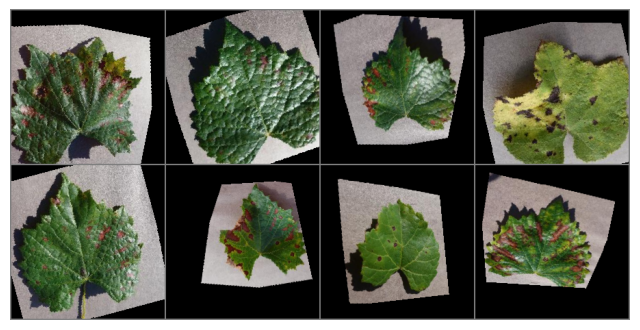

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

mean = np.array(image_processor.image_mean)
std = np.array(image_processor.image_std)

# Unnormalize and make a grid
grid = vutils.make_grid(images, nrow=4, padding=2)
grid = grid.cpu().numpy().transpose(1, 2, 0)
grid = std * grid + mean  # unnormalize
grid = np.clip(grid, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')
plt.show()

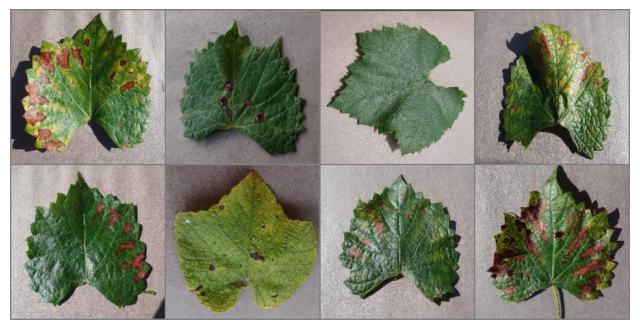

In [7]:
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
dataiter = iter(val_dataloader)
images, labels = next(dataiter)

mean = np.array(image_processor.image_mean)
std = np.array(image_processor.image_std)

# Unnormalize and make a grid
grid = vutils.make_grid(images, nrow=4, padding=2)
grid = grid.cpu().numpy().transpose(1, 2, 0)
grid = std * grid + mean  # unnormalize
grid = np.clip(grid, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis('off')
plt.show()

### Training Function


In [8]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

### Validation Function


In [9]:
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(val_loader)
    return avg_loss, accuracy

### Main Function


In [ ]:
import os

os.makedirs(dir, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
def train_with_sweep():
    # Initialize W&B
    wandb.init()

    # Get hyperparameters from W&B
    config = wandb.config

    # Set up model
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224", 
        num_labels=config.num_classes, 
        ignore_mismatched_sizes=True)
    model.to(device)    

    # Set up optimizer and criterion
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config.learning_rate
        )
    criterion = nn.CrossEntropyLoss()

    # Dynamically set batch size in DataLoader
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    patience = 10  # Stop training if no improvement for 'patience' epochs
    min_delta = 1e-4  # Minimum change in val_loss to qualify as improvement
    best_val_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(config.num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")

        # Validation
        val_loss, val_accuracy = validate(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Log metrics to W&B
        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'epoch': epoch + 1
        })

        # Check early stopping criteria
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
            # Save the model if it's the best so far
            torch.save(model.state_dict(), f'{dir}/model_lr{config.learning_rate}_bs{config.batch_size}.pth')
            print(f"New best model saved. Validation Loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        # Early stopping condition
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print("Evaluating the best model on the test dataset...")
    model.load_state_dict(torch.load(f'{dir}/model_lr{config.learning_rate}_bs{config.batch_size}.pth'))
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    # Log final test accuracy to W&B
    wandb.log({'final_test_accuracy': test_accuracy})

wandb.agent(sweep_id, function=train_with_sweep)